**Notebook Outline:**  
  
- [Setup with libraries](#Set-up-Cells)
- [Create Simulated Dataset](#Create-Simulated-Dataset)
    - [Forming independent variables](#Forming-independent-variables)
    - [Creating y variable with Poisson distribution](#Creating-y-variable-with-Poisson-distribution)
- [Univariate example](#Univariate-example)
    - [Bandwidth: Random initialization check](#Bandwidth:-Random-initialization-check)
    - [Parameters check](#Parameters-check)
- [Multivariate example](#Multivariate-example)
    - [Bandwidths: Random initialization check](#Bandwidths:-Random-initialization-check)
    - [Parameters check](#Parameters-check)
- [Global model parameter check](#Global-model-parameter-check)

### Set up Cells

In [1]:
import sys
#change path here to point to your folder
sys.path.append("C:/Users/msachde1/Downloads/Research/Development/mgwr")

In [2]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np

from mgwr.gwr import GWR
from spglm.family import Gaussian, Binomial, Poisson
from mgwr.gwr import MGWR
from mgwr.sel_bw import Sel_BW
import multiprocessing as mp
pool = mp.Pool()
from scipy import linalg
import numpy.linalg as la
from scipy import sparse as sp
from scipy.sparse import linalg as spla
from spreg.utils import spdot, spmultiply
from scipy import special
import libpysal as ps
import seaborn as sns
import matplotlib.pyplot as plt
from copy import deepcopy
import copy
from collections import namedtuple
import spglm

### Create Simulated Dataset

#### Forming independent variables

In [3]:
def add(a,b):
    return 1+((1/120)*(a+b))

def con(u,v):
    return (0*(u)*(v))+0.3

def sp(u,v):
    return 1+1/3240*(36-(6-u/2)**2)*(36-(6-v/2)**2)

In [4]:
x = np.linspace(0, 25, 25)
y = np.linspace(25, 0, 25)
X, Y = np.meshgrid(x, y)

In [5]:
x1=np.random.normal(0,1,625)
x2=np.random.normal(0,1,625)
error = np.random.normal(0,0.1,625)

In [6]:
B0=con(X,Y)
B1=add(X,Y)
B2=sp(X,Y)

([], <a list of 0 Text yticklabel objects>)

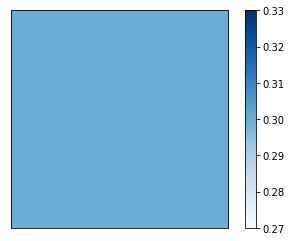

In [7]:
plt.imshow(B0, extent=[0,10, 0, 10], origin='lower',cmap='Blues')
plt.colorbar()
plt.axis(aspect='image')
plt.xticks([])
plt.yticks([])

([], <a list of 0 Text yticklabel objects>)

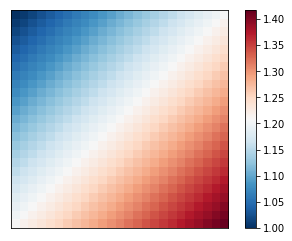

In [8]:
plt.imshow(B1, extent=[0,10, 0, 10], origin='lower',cmap='RdBu_r')
plt.colorbar()
plt.axis(aspect='image')
plt.xticks([])
plt.yticks([])

([], <a list of 0 Text yticklabel objects>)

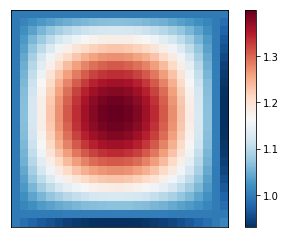

In [9]:
plt.imshow(B2, extent=[0,25, 0, 25], origin='lower',cmap='RdBu_r')
plt.colorbar()
plt.axis(aspect='image')
plt.xticks([])
plt.yticks([])

In [10]:
B0=B0.reshape(-1,1)
B1=B1.reshape(-1,1)
B2=B2.reshape(-1,1)

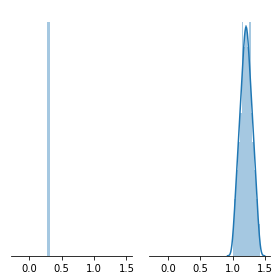

In [11]:
f, axes = plt.subplots(1, 2, figsize=(4, 4), sharex=True)
sns.despine(left=True)
sns.distplot(B0,ax=axes[0])
sns.distplot(B1,ax=axes[1])

plt.setp(axes, yticks=[])
plt.tight_layout()

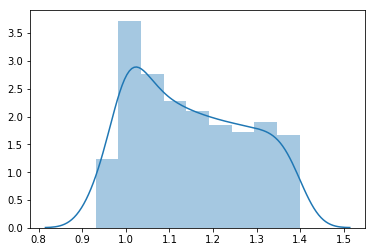

In [12]:
sns.distplot(B2)

In [13]:
lat=Y.reshape(-1,1)
lon=X.reshape(-1,1)

In [14]:
x1=x1.reshape(-1,1)
x2=x2.reshape(-1,1)

In [15]:
param = np.hstack([B0,B1,B2])
cons=np.ones_like(x1)
X=np.hstack([cons,x1,x2])

In [16]:
param.shape,X.shape

((625, 3), (625, 3))

#### Creating y variable with Poisson distribution
Incorporating step from - Chapter 6. Simulating Generalized Linear Models, p. 153

In [17]:
#y
y=(np.exp((np.sum(X * param, axis=1)+error).reshape(-1, 1)))
y_new = np.random.poisson(y)

In [18]:
y.shape

(625, 1)

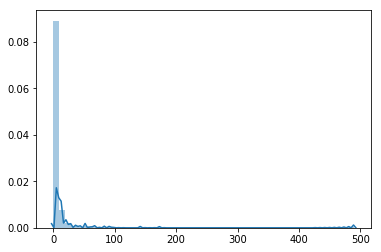

In [19]:
sns.distplot(y)

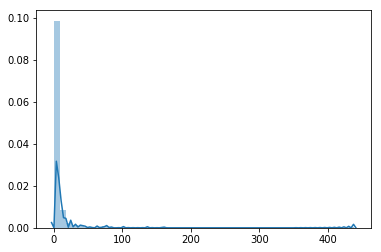

In [20]:
sns.distplot(y_new)

In [21]:
coords = np.array(list(zip(lon,lat)))
y = np.array(y_new).reshape((-1,1))

In [22]:
x=x1
x_std = (x-x.mean(axis=0))/x.std(axis=0)
X=np.hstack([x1,x2])
X_std = (X-X.mean(axis=0))/X.std(axis=0)

### Univariate example

#### First example: checking GWR and MGWR models with one independent variable and constant = False

In [23]:
bw=Sel_BW(coords,y,x,family=Poisson(),offset=None,constant=False)
bw=bw.search()
gwr_model=GWR(coords,y,x,bw,family=Poisson(),offset=None,constant=False).fit()
bw

43.0

In [24]:
selector=Sel_BW(coords,y,x,multi=True,family=Poisson(),offset=None,constant=False)
selector.search(verbose=True, rss_score=True)

Current iteration: 1 ,SOC: 0.0
Bandwidths: 43.0


array([43.])

In [25]:
mgwr_model=MGWR(coords,y,x,selector,family=Poisson(),offset=None,constant=False).fit()

#### Bandwidth: Random initialization check

In [26]:
selector.search(verbose=True,init_multi=600)

Current iteration: 1 ,SOC: 0.023205
Bandwidths: 43.0
Current iteration: 2 ,SOC: 0.0
Bandwidths: 43.0


array([43.])

#### Parameters check

In [27]:
np.sum(((gwr_model.params-mgwr_model.params)==0.0)==True)

625

In [28]:
gwr_model.aic,mgwr_model.aic

(4330.024596599273, 4266.854231511965)

In [29]:
np.sum((gwr_model.predy-mgwr_model.predy==0)==True)

625

### Multivariate example

#### Second example for multiple bandwidths

In [30]:
bw=Sel_BW(coords,y,X,family=Poisson(),offset=None)
bw=bw.search()
gwr_model=GWR(coords,y,X,bw,family=Poisson(),offset=None).fit()
bw

162.0

In [31]:
selector=Sel_BW(coords,y,X,multi=True,family=Poisson(),offset=None)
selector.search(verbose=True)

Current iteration: 1 ,SOC: 0.0063221
Bandwidths: 455.0, 455.0, 60.0
Current iteration: 2 ,SOC: 0.0007777
Bandwidths: 624.0, 457.0, 61.0
Current iteration: 3 ,SOC: 1.78e-05
Bandwidths: 624.0, 457.0, 61.0
Current iteration: 4 ,SOC: 2.1e-06
Bandwidths: 624.0, 457.0, 61.0


array([624., 457.,  61.])

#### Bandwidths: Random initialization check

In [32]:
selector.search(verbose=True,init_multi=600)

Current iteration: 1 ,SOC: 0.0117993
Bandwidths: 402.0, 134.0, 77.0
Current iteration: 2 ,SOC: 0.0043856
Bandwidths: 624.0, 44.0, 60.0
Current iteration: 3 ,SOC: 0.0005842
Bandwidths: 624.0, 44.0, 60.0
Current iteration: 4 ,SOC: 0.0001745
Bandwidths: 624.0, 44.0, 60.0
Current iteration: 5 ,SOC: 6.19e-05
Bandwidths: 624.0, 44.0, 60.0
Current iteration: 6 ,SOC: 2.25e-05
Bandwidths: 624.0, 44.0, 60.0
Current iteration: 7 ,SOC: 8.2e-06
Bandwidths: 624.0, 44.0, 60.0


array([624.,  44.,  60.])

In [33]:
mgwr_model=MGWR(coords,y,X,selector,family=Poisson(),offset=None).fit()

#### Parameters check

In [34]:
max(gwr_model.predy-mgwr_model.predy)[:10]

array([134.83018867])

In [35]:
gwr_model.aic, mgwr_model.aic

(696.7491366565467, 3247.395870625656)

### Global model parameter check

In [36]:
import statsmodels.api as sma

In [37]:
X_glob=sma.add_constant(X)

In [38]:
poisson_mod = sma.Poisson(y, X_glob)

In [39]:
poisson_res = poisson_mod.fit(method="newton")
print(poisson_res.summary())

Optimization terminated successfully.
         Current function value: 1.705962
         Iterations 8
                          Poisson Regression Results                          
Dep. Variable:                      y   No. Observations:                  625
Model:                        Poisson   Df Residuals:                      622
Method:                           MLE   Df Model:                            2
Date:                Thu, 15 Aug 2019   Pseudo R-squ.:                  0.8344
Time:                        11:29:38   Log-Likelihood:                -1066.2
converged:                       True   LL-Null:                       -6438.5
                                        LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2623      0.034      7.721      0.000       0.196       0.329
x1             1.2202      0.

In [40]:
selector=Sel_BW(coords,y,X,multi=True,family=Poisson(),offset=None)

In [41]:
selector.search(verbose=True,multi_bw_min=[625,625,625], multi_bw_max=[625,625,625])

Current iteration: 1 ,SOC: 0.0058148
Bandwidths: 625.0, 625.0, 625.0
Current iteration: 2 ,SOC: 0.0009443
Bandwidths: 625.0, 625.0, 625.0
Current iteration: 3 ,SOC: 0.0001478
Bandwidths: 625.0, 625.0, 625.0
Current iteration: 4 ,SOC: 3e-06
Bandwidths: 625.0, 625.0, 625.0


array([625., 625., 625.])

In [42]:
mgwr_model=MGWR(coords,y,X,selector,family=Poisson(),offset=None).fit()

In [44]:
np.mean(mgwr_model.params,axis=0)

array([0.31376269, 1.19092495, 1.17748787])

##### parameters similar for global Poisson model and forced global MGWR Poisson model